#### Step 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")


#### Step 2: Load and Preprocess Data

In [2]:
file_path = r"/home/petpooja/Documents/other projects/Consumption Dataset - Dataset.csv" # Load the inventory dataset
data = pd.read_csv(file_path)
data.rename(columns={"Date Time Served": "Date"}, inplace=True) # Rename and convert Date column
data['Date'] = pd.to_datetime(data['Date'])
data['Item_ID'] = data['Bar Name'] + "_" + data['Alcohol Type'] + "_" + data['Brand Name'] # Create Item_ID to uniquely identify item
data = data.sort_values(by='Date').reset_index(drop=True)


####  Step 3: Analyze Consumption Patterns

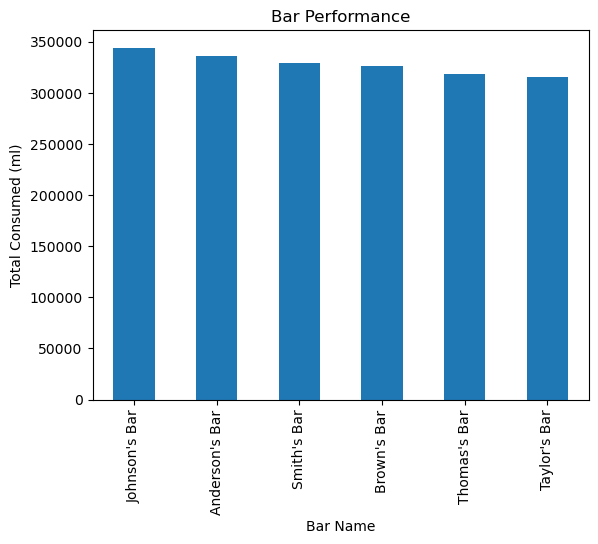

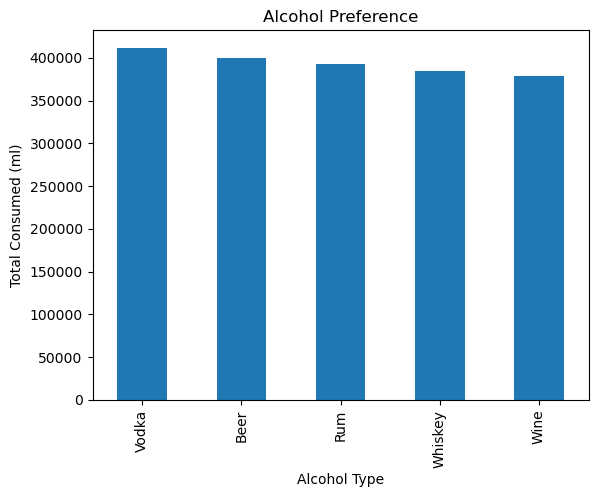

In [3]:
bar_perf = data.groupby('Bar Name')['Consumed (ml)'].sum().sort_values(ascending=False)# Group by Bar Name for performance
alcohol_pref = data.groupby('Alcohol Type')['Consumed (ml)'].sum().sort_values(ascending=False) # Alcohol preference
bar_perf.plot(kind='bar', title='Bar Performance'); plt.ylabel("Total Consumed (ml)"); plt.show()
alcohol_pref.plot(kind='bar', title='Alcohol Preference'); plt.ylabel("Total Consumed (ml)"); plt.show()


#### Step 4: Train Forecasting Models (Per Item)

In [4]:
forecast_models = {}
for item_id in data['Item_ID'].unique():
    item_df = data[data['Item_ID'] == item_id].copy()
    daily = item_df.groupby('Date')['Consumed (ml)'].sum().reset_index()
    if len(daily) < 5: continue
    daily['Day_Index'] = range(len(daily))
    X = daily[['Day_Index']]
    y = daily['Consumed (ml)']
    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)
    mae = np.mean(np.abs(predictions - y))
    forecast_models[item_id] = {'model': model, 'mae': mae, 'base_index': len(daily)}


#### Step 5: Calculate Optimal Par Levels

In [5]:
par_levels = {}
for item_id in data['Item_ID'].unique():
    item_data = data[data['Item_ID'] == item_id]
    recent = item_data[item_data['Date'] >= item_data['Date'].max() - pd.Timedelta(days=30)]
    avg_daily = recent['Consumed (ml)'].sum() / 30
    std_dev = recent['Consumed (ml)'].std()
    par = avg_daily * 7
    safety = std_dev if not np.isnan(std_dev) else 0
    reorder = avg_daily * 2   #average par levels on daily basis
    par_levels[item_id] = {
        'avg_daily_consumption': avg_daily,
        'par_level': par,
        'safety_stock': safety,
        'reorder_point': reorder
    }


#### Step 6: Simulate Inventory Management

In [6]:
simulation_results = {}
for item_id, par in par_levels.items():
    closing_bal = data[data['Item_ID'] == item_id]['Closing Balance (ml)'].iloc[-1]
    inv = [closing_bal]
    stockouts, overstock, orders = 0, 0, 0
    for day in range(30):
        forecasted = forecast_models[item_id]['model'].predict([[forecast_models[item_id]['base_index'] + day]])[0]
        demand = max(0, forecasted + np.random.normal(0, par['avg_daily_consumption'] * 0.2))
        if inv[-1] <= par['reorder_point']:
            order = par['par_level'] - inv[-1]
            inv[-1] += order
            orders += 1
        used = min(inv[-1], demand)
        remain = inv[-1] - used
        if used < demand:
            stockouts += 1
        if remain > par['par_level'] * 1.2:
            overstock += 1
        inv.append(remain)
    service = (30 - stockouts) / 30
    turnover = (par['avg_daily_consumption'] * 30) / np.mean(inv) 
    simulation_results[item_id] = {
        'service_level': service,
        'stockout_days': stockouts,
        'overstock_days': overstock,
        'total_orders': orders,
        'avg_inventory': np.mean(inv),
        'inventory_turnover': turnover,
        'final_inventory': inv[-1]
    }
# 30 days consuption

#### Step 7: Generate Recommendations

In [7]:
recommendations = []
for item_id, par in par_levels.items():
    current = data[data['Item_ID'] == item_id]['Closing Balance (ml)'].iloc[-1]
    if current < par['reorder_point']:
        urgency = "HIGH" if current < par['safety_stock'] else "MEDIUM"
        order_qty = par['par_level'] - current
        action = "REORDER"
        reason = f"Stock below reorder point ({par['reorder_point']:.0f}ml)"
    elif current > par['par_level'] * 1.5:
        urgency = "LOW"
        order_qty = 0
        action = "REDUCE"     
        reason = "Overstock - consider reducing orders"
    else:
        continue
    bar, alc, brand = item_id.split('_')
    recommendations.append({
        'item_id': item_id, 'bar_name': bar, 'alcohol_type': alc, 'brand_name': brand,
        'action': action, 'urgency': urgency,
        'current_stock': current, 'recommended_order': order_qty,
        'par_level': par['par_level'], 'reason': reason
    })
recommendations = sorted(recommendations, key=lambda x: (x['urgency'] == 'HIGH', x['urgency'] == 'MEDIUM'), reverse=True)


 #### Step 8: Generate Dashboard Summary

In [8]:
summary = {
    'total_consumption_liters': data['Consumed (ml)'].sum() / 1000,
    'total_purchases_liters': data['Purchase (ml)'].sum() / 1000,
    'unique_items': data['Item_ID'].nunique(),
    'unique_bars': data['Bar Name'].nunique(),
    'avg_inventory_turnover': np.mean([r['inventory_turnover'] for r in simulation_results.values()]),
    'top_performing_bar': data.groupby('Bar Name')['Consumed (ml)'].sum().idxmax(),
    'most_popular_alcohol': data.groupby('Alcohol Type')['Consumed (ml)'].sum().idxmax(),
    'forecasting_accuracy': np.mean([r['mae'] for r in forecast_models.values()])
}
summary

{'total_consumption_liters': np.float64(1968.68166),
 'total_purchases_liters': np.float64(2076.65955),
 'unique_items': 96,
 'unique_bars': 6,
 'avg_inventory_turnover': np.float64(nan),
 'top_performing_bar': "Johnson's Bar",
 'most_popular_alcohol': 'Vodka',
 'forecasting_accuracy': np.float64(151.87355006179266)}

####  Step 9: Display Final Outputs

In [9]:
print("===== DASHBOARD SUMMARY =======")
print(f"Total Consumption: {summary['total_consumption_liters']:.1f} L")
print("\nTop Recommendations:")
for rec in recommendations[:5]:
    print(f"- {rec['item_id']}: {rec['action']} ({rec['urgency']}) | {rec['reason']}")
print("\nTop Simulation Results:")
top_sim = sorted(simulation_results.items(), key=lambda x: x[1]['service_level'], reverse=True)[:5]
for item, res in top_sim:
    print(f"Item: {item} | Service Level: {res['service_level']*100:.2f}% | Inventory Turnover: {res['inventory_turnover']:.2f}")


===== DASHBOARD SUMMARY =======
Total Consumption: 1968.7 L

Top Recommendations:
- Brown's Bar_Vodka_Grey Goose: REORDER (HIGH) | Stock below reorder point (73ml)
- Taylor's Bar_Wine_Sutter Home: REORDER (HIGH) | Stock below reorder point (153ml)
- Anderson's Bar_Beer_Miller: REORDER (HIGH) | Stock below reorder point (56ml)
- Johnson's Bar_Wine_Yellow Tail: REORDER (HIGH) | Stock below reorder point (157ml)
- Johnson's Bar_Whiskey_Jameson: REORDER (HIGH) | Stock below reorder point (97ml)

Top Simulation Results:
Item: Taylor's Bar_Wine_Sutter Home | Service Level: 100.00% | Inventory Turnover: 5.58
Item: Brown's Bar_Rum_Captain Morgan | Service Level: 100.00% | Inventory Turnover: 3.36
Item: Thomas's Bar_Rum_Captain Morgan | Service Level: 100.00% | Inventory Turnover: 1.09
Item: Taylor's Bar_Beer_Coors | Service Level: 100.00% | Inventory Turnover: 0.28
Item: Brown's Bar_Whiskey_Jack Daniels | Service Level: 100.00% | Inventory Turnover: 1.86
